<a href="https://colab.research.google.com/github/zhouchun0105/Fake-News-Detection-Project-BA865/blob/main/BA865_word_frequency_and_sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
# Importing all necessary libraries and imports

# Basics
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# sklearn
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# NLTK 
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Setup and Data Cleaning

In [28]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [29]:
# Import data 
df_fakenews_true = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/True.csv")
df_fakenews_fake = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/Fake.csv")

In [30]:
df_fakenews_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [31]:
df_fakenews_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [32]:
df_fakenews_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [33]:
df_fakenews_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [34]:
print(df_fakenews_true.shape)
print(df_fakenews_fake.shape)

(21417, 4)
(23481, 4)


In [35]:
# checking for any null values
df_fakenews_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [36]:
# checking for any null values
df_fakenews_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

# Data Pre-Processing

In [37]:
# creating new colum 'Real/Fake', labeling the two datasets in order to merge and know which observation is real and which one is false
df_fakenews_true['real/fake'] = '1'
df_fakenews_fake['real/fake'] = '0'

In [38]:
# merging the two datasets
frames = [df_fakenews_true, df_fakenews_fake]
news_data_all = pd.concat(frames)
news_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   real/fake  44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [39]:
#Removing links and the headline from the date column
news_data_all = news_data_all[news_data_all.date.str.contains('Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec')]

In [40]:
news_data_all['date'] = pd.to_datetime(news_data_all['date'])

In [41]:
news_data_all.head()

,title,text,subject,date,real/fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [42]:
news_data_all.describe()

,title,text,subject,date,real/fake
count,44888,44888,44888,44888,44888
unique,38723,38640,8,1010,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,2017-12-20 00:00:00,0
freq,14,627,11272,197,23471
first,NaN,NaN,NaN,2015-03-31 00:00:00,NaN
last,NaN,NaN,NaN,2018-02-19 00:00:00,NaN


In [43]:
# one-hot encoding for subject column
# news_data = pd.get_dummies(news_data_all, columns=["subject"])
news_data = news_data_all

In [44]:
# dropping subject column as subjects across fake and real news articles are unbalanced
news_data = news_data.drop('subject', axis=1)

In [45]:
# title and text can be two seperate variables
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      44888 non-null  object        
 1   text       44888 non-null  object        
 2   date       44888 non-null  datetime64[ns]
 3   real/fake  44888 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.7+ MB


# Text Processing

In [46]:
import re
import string

In [47]:
# merging the title and news text
news_data['content'] = news_data['title']+' '+news_data['text']
news_dataset = news_data.drop(['title', 'text'], axis=1)

News-Punctuation Cleaning

In [48]:
#Creating a copy 
clean_news=news_dataset.copy()

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    


In [49]:
clean_news['content'] = clean_news['content'].apply(lambda x:review_cleaning(x))
clean_news.head()

,date,real/fake,content
0,2017-12-31,1,as us budget fight looms republicans flip thei...
1,2017-12-29,1,us military to accept transgender recruits on ...
2,2017-12-31,1,senior us republican senator let mr mueller do...
3,2017-12-30,1,fbi russia probe helped by australian diplomat...
4,2017-12-29,1,trump wants postal service to charge much more...


News-Stop words

In [50]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
# removing english stopwords to save space and processing time
stop = stopwords.words('english')
clean_news['content'] = clean_news['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,date,real/fake,content
0,2017-12-31,1,us budget fight looms republicans flip fiscal ...
1,2017-12-29,1,us military accept transgender recruits monday...
2,2017-12-31,1,senior us republican senator let mr mueller jo...
3,2017-12-30,1,fbi russia probe helped australian diplomat ti...
4,2017-12-29,1,trump wants postal service charge much amazon ...


In [52]:
clean_news['real/fake'] = clean_news['real/fake'].astype(int)

In [53]:
clean_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       44888 non-null  datetime64[ns]
 1   real/fake  44888 non-null  int64         
 2   content    44888 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.4+ MB


# EDA

(-0.5, 1299.5, 949.5, -0.5)

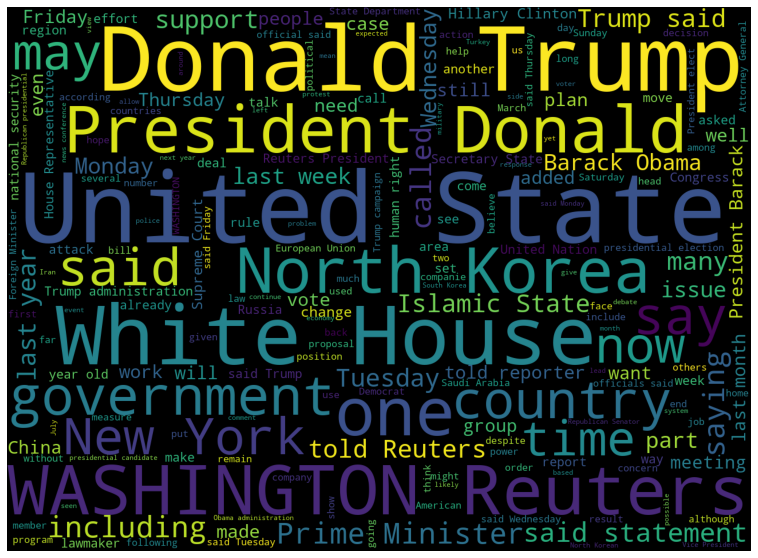

In [31]:
# word cloud for the text real true News
text_true = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_true.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1299.5, 949.5, -0.5)

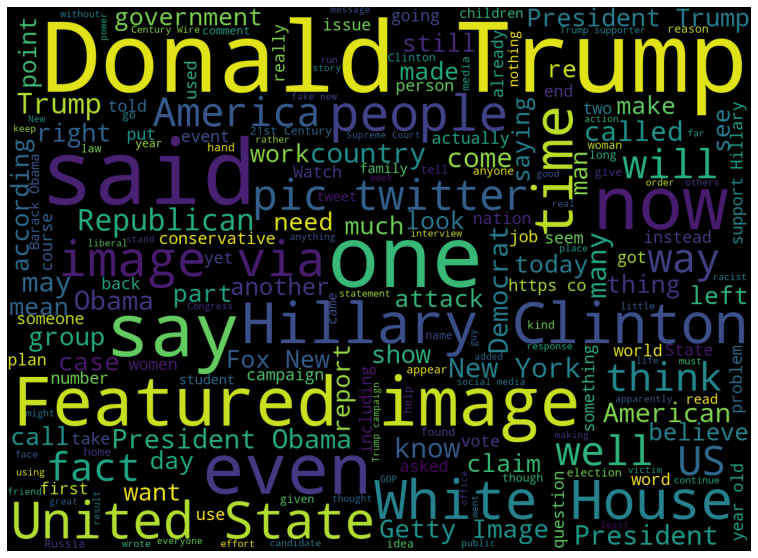

In [32]:
# word cloud for the text false fake News
text_false = pd.Series(df_fakenews_fake['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_false.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [33]:
# subsetting the cleaned, preprocessed news data for real and fake
top_words_real = clean_news[clean_news['real/fake'] == 1]
top_words_fake = clean_news[clean_news['real/fake'] == 0]

In [34]:
from collections import Counter

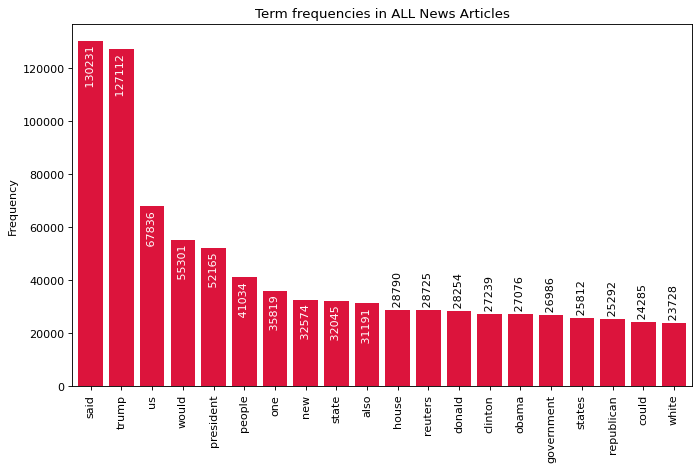

In [37]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(clean_news['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in ALL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
#plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

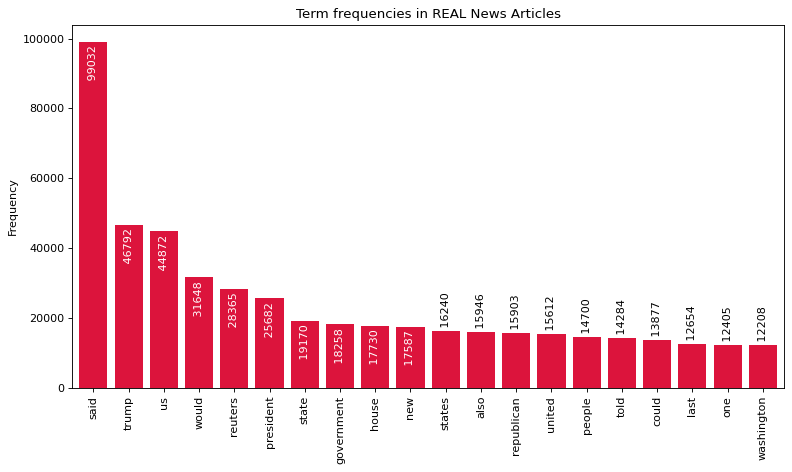

In [38]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_real['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in REAL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

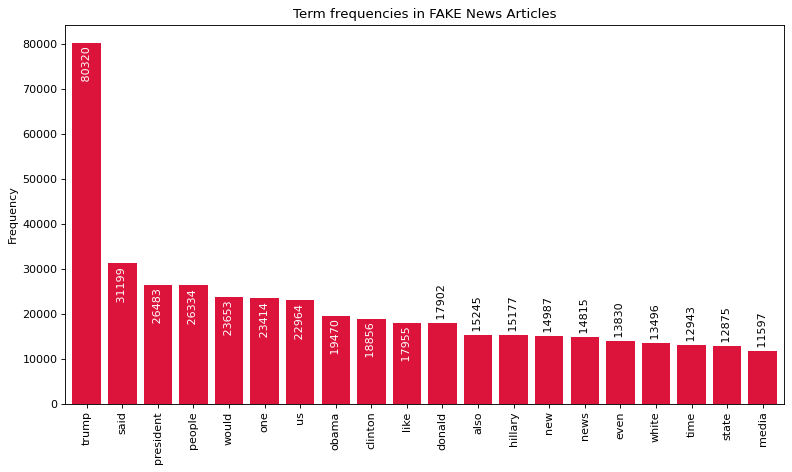

In [39]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_fake['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in FAKE News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

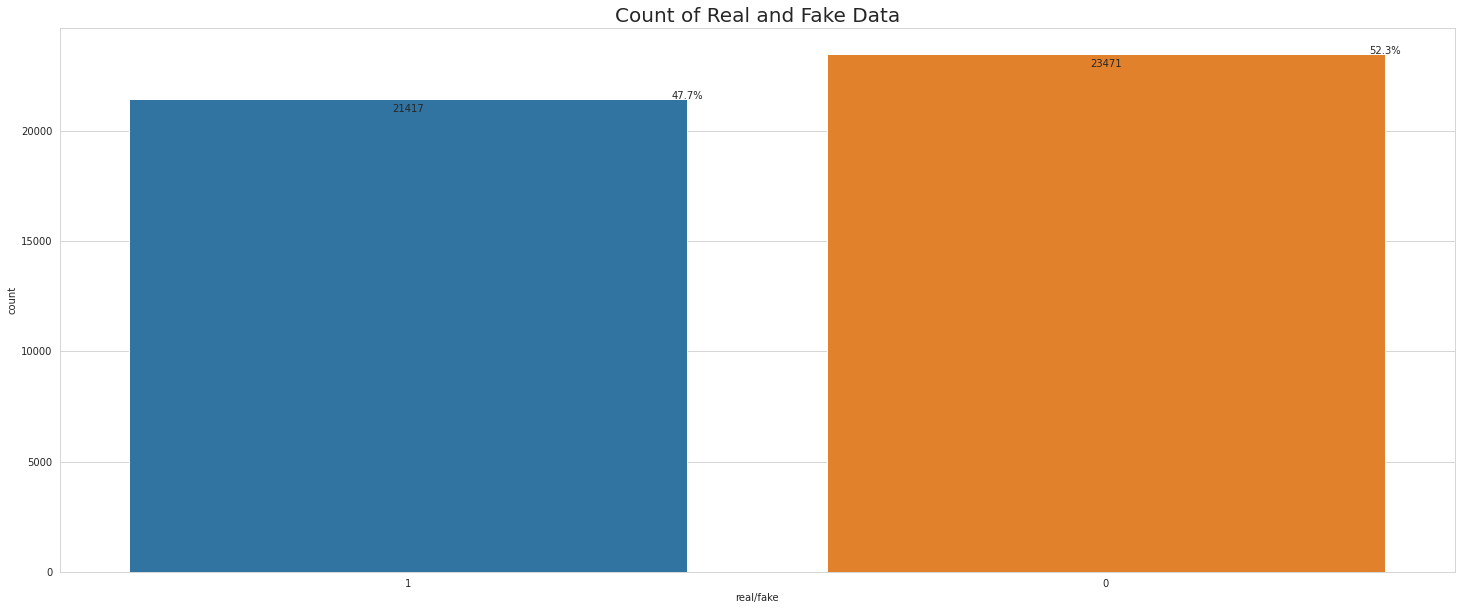

In [40]:
total = float(len(news_data))

sns.set_style('whitegrid')
plt.figure(figsize= (25,10))
fig = sns.countplot(x='real/fake', data= news_data)
plt.title('Count of Real and Fake Data', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')

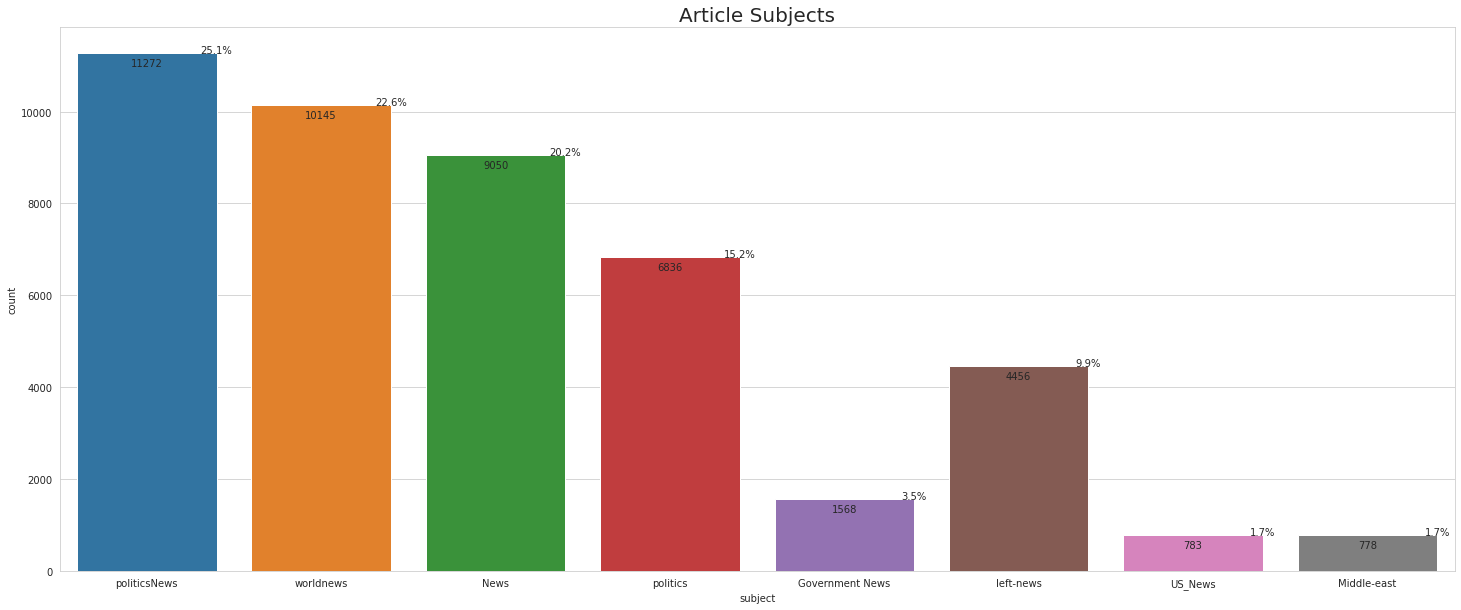

In [41]:
#order=['unknown','Activated','Pending Activation','Inactivated','Non Standard MyChart Status','Patient Declined','Activation Code Generated, but Disabled']
total = float(len(news_data))


plt.figure(figsize= (25,10))
fig = sns.countplot(x='subject', data= news_data_all)
plt.title('Article Subjects', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')


In [42]:
count = news_data_all.groupby(['subject','real/fake']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()
count

,subject,real/fake,count
0,politicsNews,1,11272
1,worldnews,1,10145
2,News,0,9050
3,politics,0,6836
4,left-news,0,4456
5,Government News,0,1568
6,US_News,0,783
7,Middle-east,0,778


In [43]:
df_fakenews_true.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,politicsNews,11272
1,worldnews,10145


In [44]:
df_fakenews_fake.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,News,9050
1,politics,6841
2,left-news,4459
3,Government News,1570
4,US_News,783
5,Middle-east,778


Time Serires Real/Fake News

# Import libraries

In [54]:
# installs
! pip install pandas-gbq
! pip install wordcloud
! pip install emoji
! pip install nltk
! pip install scikit-plot
! pip install umap-learn
! pip install afinn
! pip install -U spacy
! pip install spacytextblob

     |████████████████████████████████| 175 kB 30.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=47d627d81f0d513e0c630dbd2c7e078bc523871141833a974e485c8a9177d8de
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=0833cd4fbd63404bac4426522cd4c382da398dddd1f52c84deb426cbaa30b23d
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=53430666990c2b101eb95beaf2a31b6f7ae65f1c75113c46fff0e3b40494d710
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully bu

In [55]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplot
import re

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer  
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, WordPunctTokenizer, TweetTokenizer
from afinn import Afinn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import Text
from spacy import cli
from spacy import displacy

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# compression
from sklearn.decomposition import PCA
from umap import UMAP

In [56]:
news_dataset.head(5)

,date,real/fake,content
0,2017-12-31,1,"As U.S. budget fight looms, Republicans flip t..."
1,2017-12-29,1,U.S. military to accept transgender recruits o...
2,2017-12-31,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,2017-12-30,1,FBI Russia probe helped by Australian diplomat...
4,2017-12-29,1,Trump wants Postal Service to charge 'much mor...


In [57]:
news_data_all

,title,text,subject,date,real/fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,0


In [58]:
# Word frequency 
c_vec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=500)
# matrix of ngrams
ngrams = c_vec.fit_transform(news_dataset.content)
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'ngram'})

In [59]:
from textblob import TextBlob

In [60]:

news_dataset['polarity'] = news_dataset['content'].apply(lambda x: TextBlob(x).polarity)
news_dataset['subjective'] = news_dataset['content'].apply(lambda x: TextBlob(x).subjectivity)

In [61]:
df_ngram['polarity'] = df_ngram['ngram'].apply(lambda x: TextBlob(x).polarity)
df_ngram['subjective'] = df_ngram['ngram'].apply(lambda x: TextBlob(x).subjectivity)

In [62]:
df_ngram2 = df_ngram.sort_values(by='frequency', ascending=False)

In [63]:
df_ngram2 = df_ngram2.iloc[:20]

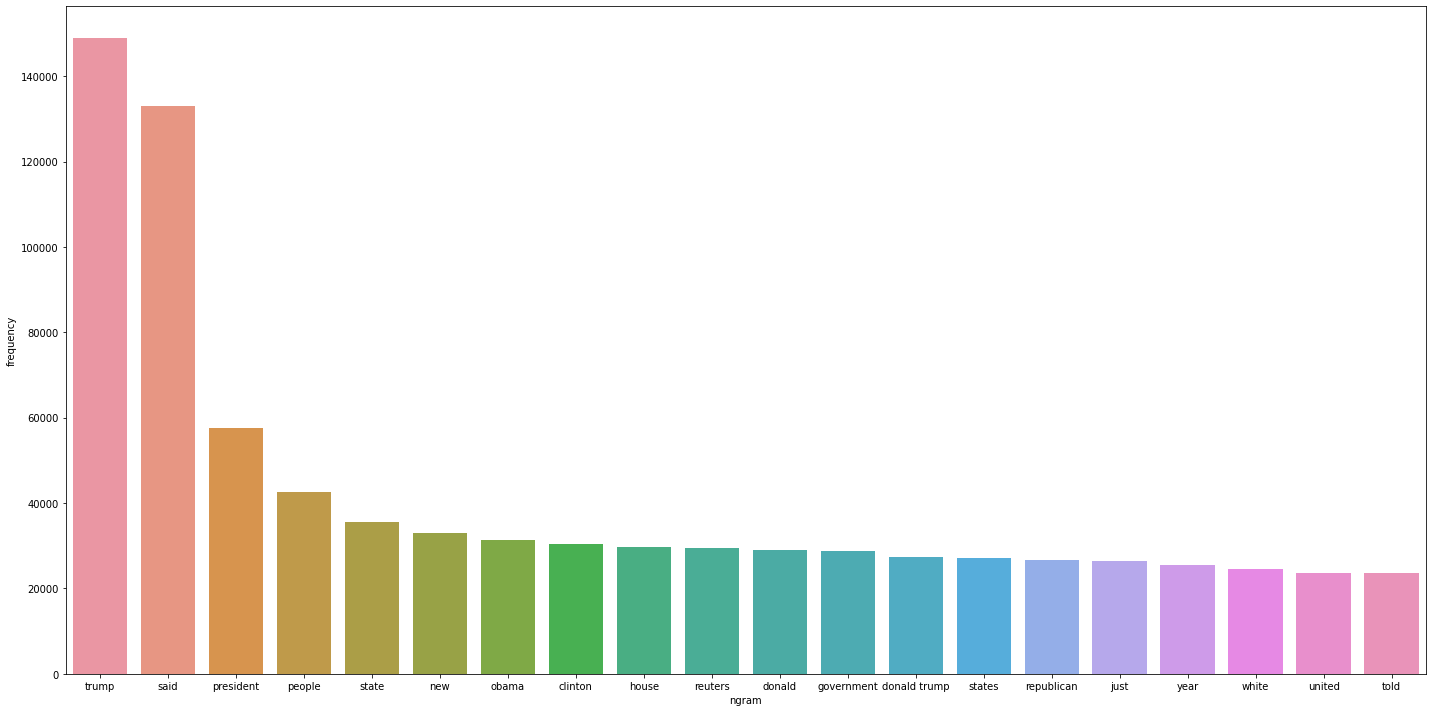

In [64]:
plt.figure(figsize= (20,10))
sns.barplot(x='ngram', y="frequency", data = df_ngram2)
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

In [65]:
# # Word frequency for only fake news 
c_vec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=500)
# matrix of ngrams
ngrams = c_vec.fit_transform(df_fakenews_fake.text)
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram1 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'ngram'})

In [66]:
df_fakenews_fake['polarity'] = df_fakenews_fake['text'].apply(lambda x: TextBlob(x).polarity)
df_fakenews_fake['subjective'] = df_fakenews_fake['text'].apply(lambda x: TextBlob(x).subjectivity)

In [67]:
df_ngram1['polarity'] = df_ngram1['ngram'].apply(lambda x: TextBlob(x).polarity)
df_ngram1['subjective'] = df_ngram1['ngram'].apply(lambda x: TextBlob(x).subjectivity)

In [68]:
df_ngram3 = df_ngram1.sort_values(by='frequency', ascending=False)

In [69]:
df_ngram3 = df_ngram3.iloc[:20]

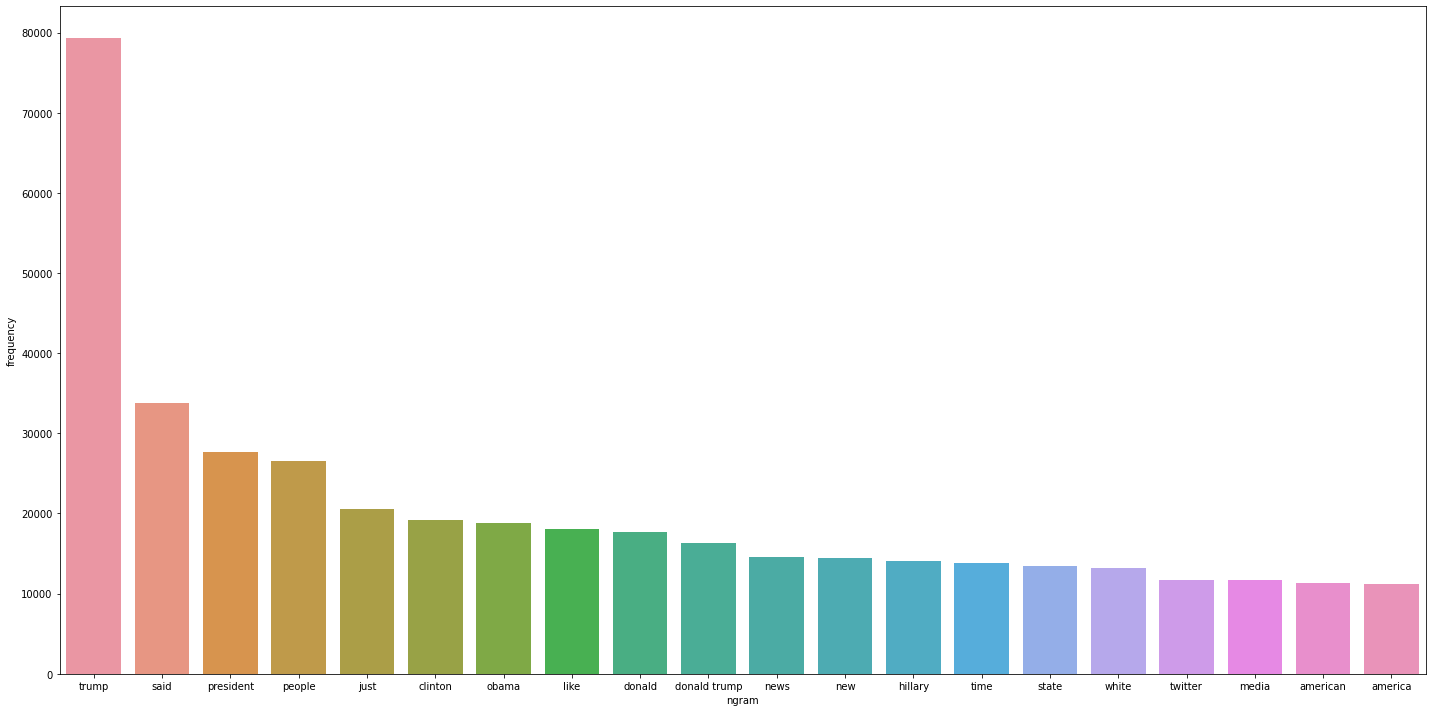

In [70]:
plt.figure(figsize= (20,10))
sns.barplot(x='ngram', y="frequency", data = df_ngram3)
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

In [71]:
# # Word frequency for only fake news 
c_vec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=500)
# matrix of ngrams
ngrams = c_vec.fit_transform(df_fakenews_true.text)
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram4 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'ngram'})

In [72]:
df_fakenews_true['polarity'] = df_fakenews_true['text'].apply(lambda x: TextBlob(x).polarity)
df_fakenews_true['subjective'] = df_fakenews_true['text'].apply(lambda x: TextBlob(x).subjectivity)

In [73]:
df_ngram4['polarity'] = df_ngram4['ngram'].apply(lambda x: TextBlob(x).polarity)
df_ngram4['subjective'] = df_ngram4['ngram'].apply(lambda x: TextBlob(x).subjectivity)

In [74]:
df_ngram5 = df_ngram4.sort_values(by='frequency', ascending=False)

In [75]:
df_ngram5 = df_ngram5.iloc[:20]

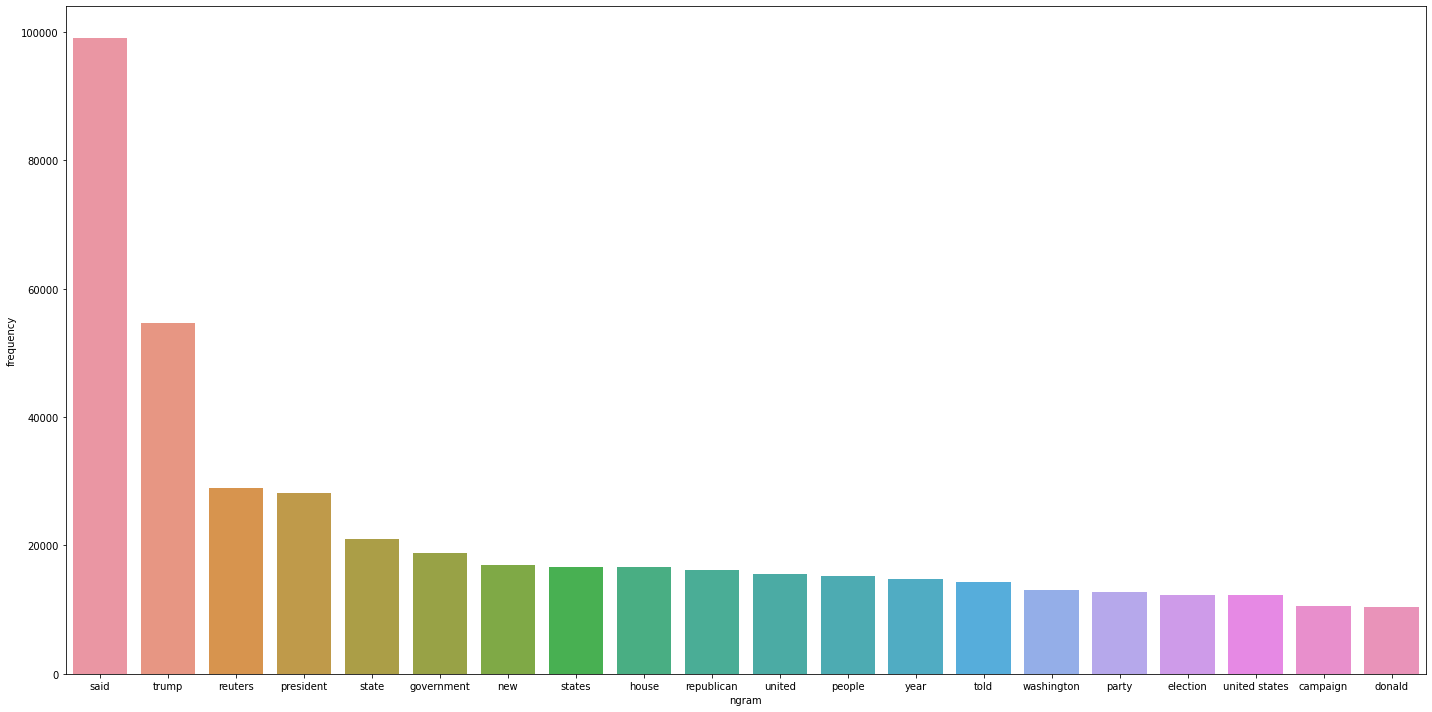

In [76]:
plt.figure(figsize= (20,10))
sns.barplot(x='ngram', y="frequency", data = df_ngram5)
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

### Sentiment Analysis

In [83]:
#sentimental Analysis 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [84]:
afinn = Afinn()

In [85]:
def sent_score(rev):
  return afinn.score(rev)

In [87]:
news_dataset.news_dataset_sent

AttributeError: ignored

In [ ]:
news_dataset_sent = news_dataset.copy()

In [ ]:
news_dataset_sent.content.str.lower()

In [ ]:
news_dataset_sent['sentiment score'] = news_dataset.content.apply(sent_score)

In [ ]:
#distribution of sentiment
plt.figure(figsize=(60,18))
ax = sns.countplot(x='sentiment score', data=news_dataset_sent)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right");

### Feature Importance 

In [82]:
news_dataset_sent

NameError: ignored

In [ ]:
news_dataset_sent.groupby('real/fake').agg({'sentiment score':'mean'})

In [ ]:
### just fake news 
news_dataset_fake = pd.DataFrame(news_dataset[news_dataset['real/fake'] == '0'])

In [ ]:
news_sent_fake = news_dataset_fake.copy()

In [ ]:
news_sent_fake['sent_fake'] = news_sent_fake.content.apply(sent_score)

In [ ]:
#distribution of sentiment for fake news 
plt.figure(figsize=(60,18))
ax = sns.countplot(x='sent_fake', data=news_sent_fake)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")

In [ ]:
### just fake news 
news_dataset_real = pd.DataFrame(news_dataset[news_dataset['real/fake'] == '1'])

In [ ]:
news_sent_real = news_dataset_real.copy()

In [ ]:
news_sent_real['sent_real'] = news_sent_real.content.apply(sent_score)

In [ ]:
#distribution of sentiment for fake news 
plt.figure(figsize=(60,18))
ax = sns.countplot(x='sent_real', data=news_sent_real)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")

# Deep Learning Models



*   LSTM
*   Bi directional LSTM
*   GloVe



### Feature Importance 

In [29]:
### shaply 

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.enable_eager_execution()

from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [30]:
clean_news

,date,real/fake,content
0,2017-12-31,1,us budget fight looms republicans flip fiscal ...
1,2017-12-29,1,us military accept transgender recruits monday...
2,2017-12-31,1,senior us republican senator let mr mueller jo...
3,2017-12-30,1,fbi russia probe helped australian diplomat ti...
4,2017-12-29,1,trump wants postal service charge much amazon ...
...,...,...,...
23476,2016-01-16,0,mcpain john mccain furious iran treated us sai...
23477,2016-01-16,0,justice yahoo settles email privacy classactio...
23478,2016-01-15,0,sunnistan us allied ‘safe zone’ plan take terr...
23479,2016-01-14,0,blow million al jazeera america finally calls ...


In [31]:
# Let's shuffle things... 
shuffled_indices= np.arange(clean_news.shape[0])
np.random.shuffle(shuffled_indices)

In [32]:
shuffled_indices

array([25111, 15750, 13968, ...,  4132, 40557, 37879])

In [33]:
clean_news_text = clean_news['content'].to_numpy()
label = np.where(clean_news['real/fake']=='Real',1,0)

In [34]:
print(clean_news_text)
clean_news_text = clean_news_text[shuffled_indices]
label = label[shuffled_indices]
print(clean_news_text)

['us budget fight looms republicans flip fiscal script washington reuters head conservative republican faction us congress voted month huge expansion national debt pay tax cuts called “fiscal conservative” sunday urged budget restraint keeping sharp pivot way among republicans us representative mark meadows speaking cbs’ “face nation” drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy even november congressional election campaigns approach republicans seek keep control congress president donald trump republicans want big budget increase military spending democrats also want proportional increases nondefense “discretionary” spending programs support education scientific research infrastructure public health environmental protection “the trump administration already willing say ‘we’re going increase nondefense discretionary spending percent’” meadows chairman s

In [35]:
#Define / Train Our Fake Review Detector
# Convert strings to sequences of words.
review_seq = []
for review in clean_news_text:
  seq = keras.preprocessing.text.text_to_word_sequence(review)
  review_seq.append(seq)


In [36]:
# Make our dictionary of term frequencies
word_freq = {}
for review in review_seq:
  for term in review:
    try:
        word_freq[term] = word_freq[term]+1
    except KeyError:
        word_freq[term] = 1


In [37]:
unique_terms = {term for review in review_seq for term in review}
print(f'We have {len(unique_terms)} unique tokens in our dataset.')


We have 226123 unique tokens in our dataset.


In [38]:
# We can then easily make a term-integer dictionary and an integer-term dictionary (for reverse lookup)

word_index = {term: number for number, term in enumerate(unique_terms)}
reverse_index = {number: term for number, term in enumerate(unique_terms)}


In [ ]:
def vectorize_sequences(sequences, dimension=len(unique_terms)): 
    
    # Make our blank matrix of 0's to store hot encodings.
    results = np.zeros((len(sequences), dimension))

    # For each observation and element in that observation,
    # Update the blank matrix to a 1 at row obs, column element value.
    for i, sequence in enumerate(sequences):
        for term in sequence:
            j = word_index[term]
            results[i, j] = 1
    return results

ta_vectorized = vectorize_sequences(review_seq)